## <center>Corn Leaf Disease Detection</center>

<center><img src="https://images.unsplash.com/photo-1503788125311-ae8d4da8ab54?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=774&q=80"></center>

## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
!pip install split-folders

In [3]:
import splitfolders

## Choosing the Device

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Splitting the Data Into Train, Validation and Test Sets

Because the data is not seperated, it should be splitted into Train, Validation and Test sets. To do that, I used splitfolders library and splitted the data into Train, Validation and Test sets by 70%, 20% and 10% respectively.

In [5]:
splitfolders.ratio("C:\\Users\\ashmi\\Downloads\\archive (2)\\data",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 4188 files [00:23, 181.08 files/s]


## Data Transformation

Resizing and Normalizing methods are applied to all of the datasets but data augmentation techniques are only applied to Train set in order to richen the data so that the model possibly will yield more accurate results.

In [6]:
#----------------------
train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# -------- Transformation for the Whole Dataset for Visualization Purposes --------
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

## Loading the Data

In [7]:
train = datasets.ImageFolder(root=r"C:\Users\ashmi\cv project\splitted_data\train",
                              transform=train_transform)

val = datasets.ImageFolder(root=r"C:\Users\ashmi\cv project\splitted_data\val",
                              transform=val_transform)

test = datasets.ImageFolder(root=r"C:\Users\ashmi\cv project\splitted_data\test",
                              transform=test_transform)

# -------- Getting the Whole Dataset for Visualization Purposes --------
data = datasets.ImageFolder(root=r"C:\Users\ashmi\Downloads\archive (2)\data",transform=data_transform)

In [8]:
print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3} 

Images per Class in TRAIN:
1    914
3    813
0    802
2    401
dtype: int64 

Images per Class in VALIDATION:
1    261
3    232
0    229
2    114
dtype: int64 

Images per Class in TEST:
1    131
3    117
0    115
2     59
dtype: int64 



#### Plotting a few Images

Images plotted below did not undergo a data augmentation process. Therefore, they seem to be normal.

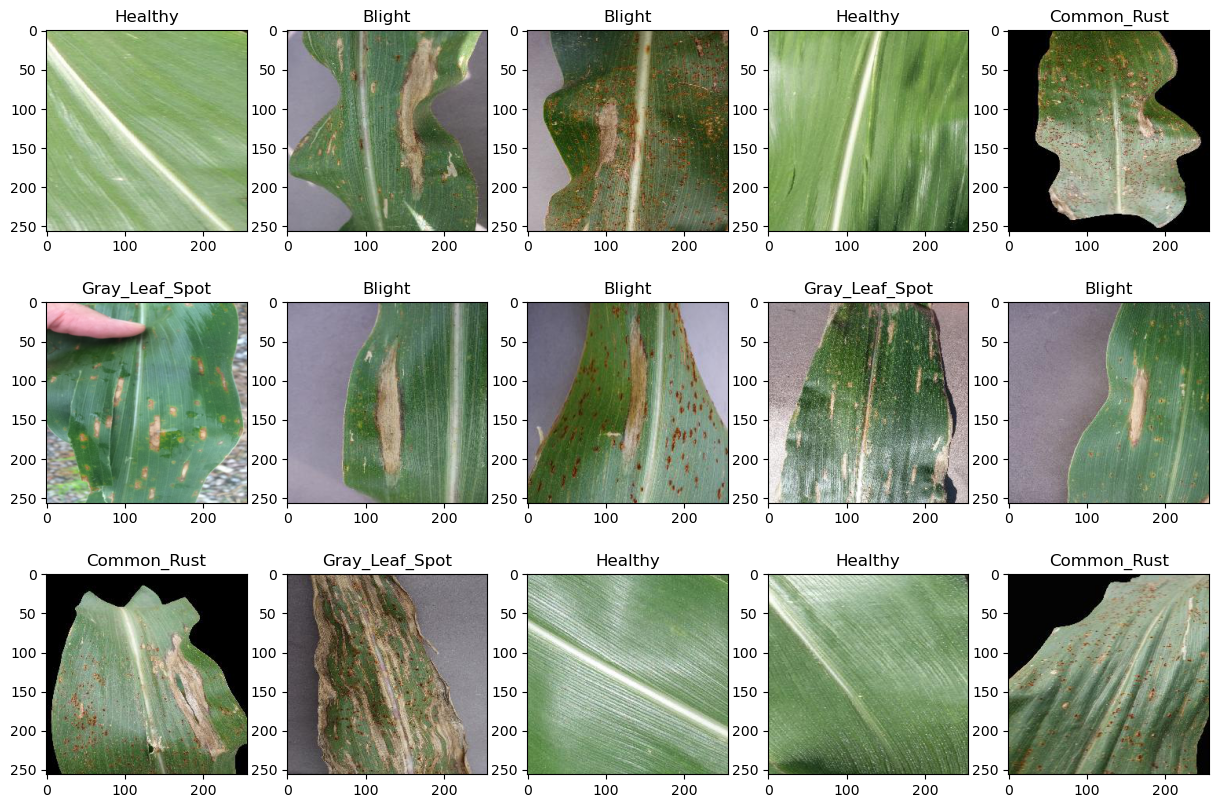

In [9]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data))
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

### Plotting the Augmented Images

Because data augmentation methods are applied to Train set, it can be seen that images are blurred, horizontally and vertically flipped compared to the unaugmented images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

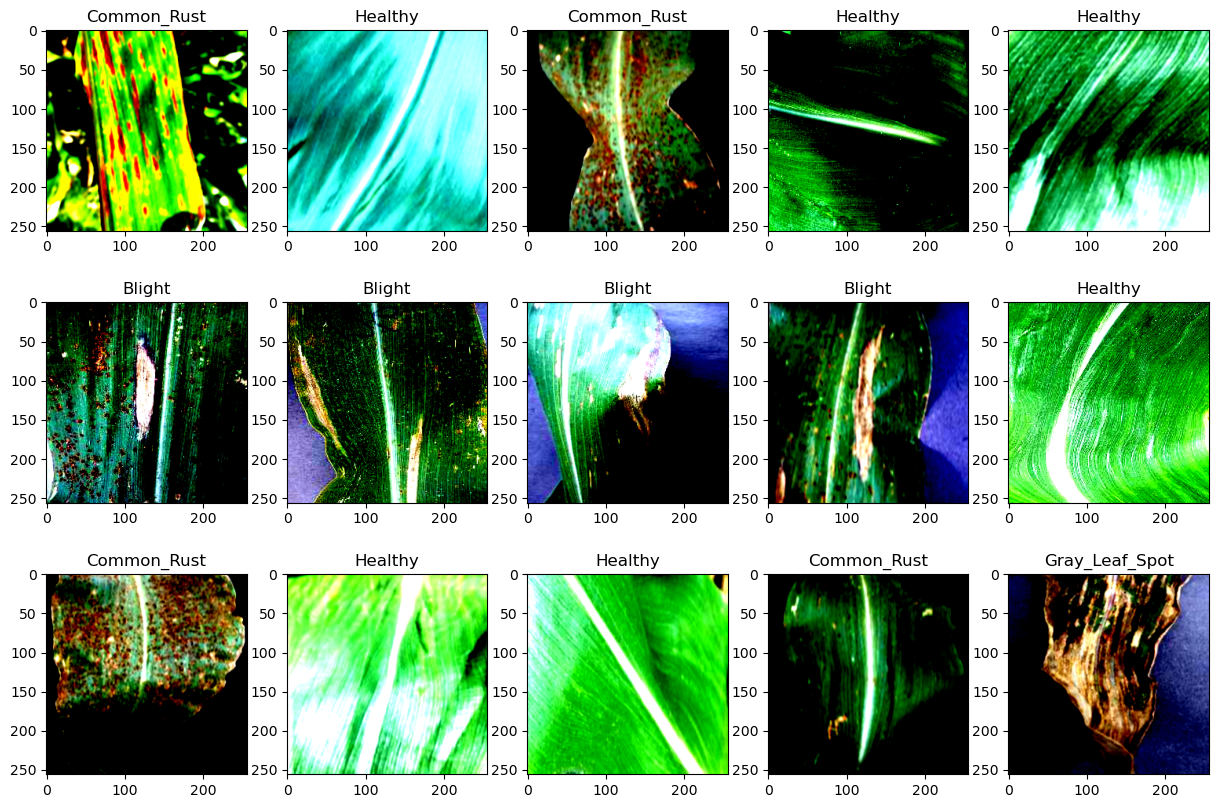

In [10]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(train))
    ax[i].imshow(train[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[train[sample][1]])

Before passing the data in a neural network, it should be batched and shuffled. Since test will not be used in training process, there is no need to shuffle it.

In [11]:
train_dataloader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

When looking at the order of the data in relevant folder, it can be observed that images from class "Blight" comes first, "Common_Rust" second, "Gray_Leaf_Spot" third and "Healthy" last. An order as such can be problematic for the model to train unbiasedly. Let's take a batch and look at the labels to make sure that the data is shuffled.

In [12]:
img, label = next(iter(train_dataloader))
print("Batch and Image Shape:", img.shape, "--> [batch_size, color_channels, height, width]")
print("\nLabels:", label)

Batch and Image Shape: torch.Size([32, 3, 256, 256]) --> [batch_size, color_channels, height, width]

Labels: tensor([2, 1, 1, 3, 3, 3, 0, 2, 0, 2, 1, 0, 2, 3, 1, 0, 1, 0, 3, 1, 1, 2, 1, 0,
        3, 1, 2, 1, 3, 1, 0, 0])


## Building the Deep Learning Model

Custom neural network architecture can be designed for this machine learning problem. With a neural network similar to the one below, an accuracy score around 80-84% is obtained. But for this project, I opt to apply Transfer Learning using ResNet18 architecture.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=131072, out_features=32), # in_features are selected based on the output that Flatten layer yields
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=4)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

## Transfer Learning - ResNet18

Transfer learning is a process of utilizing pre-trained machine learning models and applying them to a related task without need of models' learning from scratch for saving time and possibly better performance.

In [14]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=4)
model = model.to(device)

C:\Users\ashmi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ashmi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Defining the Loss Function and Choosing an Optimizer

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-3)

## Defining Train and Test Functions

In [17]:
def train_and_validate_model(num_epochs):
    val_best_accuracy = 0.0
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    print("Training begins...")
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        train_total = 0
        running_val_accuracy = 0.0
        running_val_loss = 0.0
        val_total = 0
        
        
        # TRAINING LOOP
        for data in train_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, outputs)
            _, train_predicted = torch.max(predictions, 1)
            running_train_accuracy += (train_predicted == outputs).sum().item()
            train_total += outputs.size(0)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()
            
        train_loss_value = running_train_loss/len(train_dataloader)
        train_loss_history.append(train_loss_value)
        train_accuracy = (100*running_train_accuracy)/train_total
        train_accuracy_history.append(train_accuracy)
        
        # VALIDATION LOOP
        with torch.no_grad():
            model.eval()
            for data in val_dataloader:
                inputs, outputs = data
                inputs, outputs = inputs.to(device), outputs.to(device)
                predictions = model(inputs)
                val_loss = loss_fn(predictions, outputs)
                
                _, val_predicted = torch.max(predictions, 1)
                running_val_loss += val_loss.item()
                val_total += outputs.size(0)
                running_val_accuracy += (val_predicted == outputs).sum().item()
                
        val_loss_value = running_val_loss/len(val_dataloader)
        val_loss_history.append(val_loss_value)
        val_accuracy = (100*running_val_accuracy)/val_total
        val_accuracy_history.append(val_accuracy)
        
        if val_accuracy > val_best_accuracy:
            torch.save(model.state_dict(), "model1.pth")
            val_best_accuracy = val_accuracy
        
        print("Completed Epoch: ", epoch, "- Training Accuracy: %d" %train_accuracy, "- Validation Accuracy: %d" %val_accuracy, "- Training Loss: %.4f" %train_loss_value, "- Validation Loss: %.4f" %val_loss_value)
    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

In [18]:
def test_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=4)
    model = model.to(device)
    path = "model1F.pth"
    model.load_state_dict(torch.load(path))
    model.eval()
    
    running_accuracy = 0
    total = 0
    all_predictions = []
    
    with torch.no_grad():
        for data in test_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            outputs = outputs.to(torch.float32)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
            accuracy = 100*running_accuracy/total
            
            all_predictions.append(list(predicted.to("cpu").numpy()))
        print("Test Accuracy: ", accuracy)
    return np.hstack(all_predictions) # returns a flattened array of batches of predictions

In [ ]:
EPOCHS = 1000
train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_and_validate_model(EPOCHS)
print("Training finished...\n")
all_preds = test_model()

Training begins...
Completed Epoch:  1 - Training Accuracy: 85 - Validation Accuracy: 88 - Training Loss: 0.4075 - Validation Loss: 0.2713
Completed Epoch:  2 - Training Accuracy: 84 - Validation Accuracy: 93 - Training Loss: 0.3927 - Validation Loss: 0.1951
Completed Epoch:  3 - Training Accuracy: 91 - Validation Accuracy: 90 - Training Loss: 0.2035 - Validation Loss: 0.2147
Completed Epoch:  4 - Training Accuracy: 94 - Validation Accuracy: 89 - Training Loss: 0.1432 - Validation Loss: 0.3189
Completed Epoch:  5 - Training Accuracy: 95 - Validation Accuracy: 94 - Training Loss: 0.1293 - Validation Loss: 0.1525
Completed Epoch:  6 - Training Accuracy: 96 - Validation Accuracy: 89 - Training Loss: 0.1089 - Validation Loss: 0.2846
Completed Epoch:  7 - Training Accuracy: 95 - Validation Accuracy: 94 - Training Loss: 0.1169 - Validation Loss: 0.1418
Completed Epoch:  8 - Training Accuracy: 96 - Validation Accuracy: 95 - Training Loss: 0.0914 - Validation Loss: 0.1148
Completed Epoch:  9 -

Completed Epoch:  69 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0028 - Validation Loss: 0.1766
Completed Epoch:  70 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0015 - Validation Loss: 0.1742
Completed Epoch:  71 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0018 - Validation Loss: 0.1744
Completed Epoch:  72 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0019 - Validation Loss: 0.1748
Completed Epoch:  73 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0014 - Validation Loss: 0.1785
Completed Epoch:  74 - Training Accuracy: 100 - Validation Accuracy: 96 - Training Loss: 0.0008 - Validation Loss: 0.1797
Completed Epoch:  75 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0009 - Validation Loss: 0.1809
Completed Epoch:  76 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0014 - Validation Loss: 0.1779
Completed Epoch:  77 - Training

Completed Epoch:  137 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2105
Completed Epoch:  138 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0009 - Validation Loss: 0.2114
Completed Epoch:  139 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0009 - Validation Loss: 0.2095
Completed Epoch:  140 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0013 - Validation Loss: 0.2080
Completed Epoch:  141 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0015 - Validation Loss: 0.2062
Completed Epoch:  142 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.2034
Completed Epoch:  143 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0013 - Validation Loss: 0.2126
Completed Epoch:  144 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2098
Completed Epoch:  145 - 

Completed Epoch:  205 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0015 - Validation Loss: 0.2169
Completed Epoch:  206 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2176
Completed Epoch:  207 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0012 - Validation Loss: 0.2177
Completed Epoch:  208 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0014 - Validation Loss: 0.2132
Completed Epoch:  209 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2150
Completed Epoch:  210 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0012 - Validation Loss: 0.2162
Completed Epoch:  211 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2173
Completed Epoch:  212 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0012 - Validation Loss: 0.3110
Completed Epoch:  213 - 

Completed Epoch:  273 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0013 - Validation Loss: 0.2306
Completed Epoch:  274 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2288
Completed Epoch:  275 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0012 - Validation Loss: 0.2264
Completed Epoch:  276 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2273
Completed Epoch:  277 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.2293
Completed Epoch:  278 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.2413
Completed Epoch:  279 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0009 - Validation Loss: 0.2309
Completed Epoch:  280 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0013 - Validation Loss: 0.2323
Completed Epoch:  281 - 

Completed Epoch:  341 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.3965
Completed Epoch:  342 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0013 - Validation Loss: 0.2378
Completed Epoch:  343 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0009 - Validation Loss: 0.2387
Completed Epoch:  344 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.3442
Completed Epoch:  345 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2388
Completed Epoch:  346 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2391
Completed Epoch:  347 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0008 - Validation Loss: 0.2383
Completed Epoch:  348 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2367
Completed Epoch:  349 - 

Completed Epoch:  409 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2460
Completed Epoch:  410 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2519
Completed Epoch:  411 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2455
Completed Epoch:  412 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.2426
Completed Epoch:  413 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.2444
Completed Epoch:  414 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2448
Completed Epoch:  415 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.2463
Completed Epoch:  416 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2464
Completed Epoch:  417 - 

Completed Epoch:  477 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2591
Completed Epoch:  478 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.3044
Completed Epoch:  479 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0011 - Validation Loss: 0.2582
Completed Epoch:  480 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2582
Completed Epoch:  481 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0009 - Validation Loss: 0.2579
Completed Epoch:  482 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.3220
Completed Epoch:  483 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0009 - Validation Loss: 0.2566
Completed Epoch:  484 - Training Accuracy: 99 - Validation Accuracy: 96 - Training Loss: 0.0010 - Validation Loss: 0.2565
Completed Epoch:  485 - 

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax = ax.flatten()

ax[0].plot(train_loss_history, label="Train")
ax[0].plot(val_loss_history, label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(train_accuracy_history, label="Train")
ax[1].plot(val_accuracy_history, label="Validation")
ax[1].title.set_text("Accuracy Score")
ax[1].legend()

plt.show()

In [ ]:
print(classification_report(test.targets, all_preds))

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

## Manual Testing

It is always a good practice to test the model manually and try to understand what is going on in prediction. Let's choose a single sample out of test set and make the model predict that single image.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In the code above, I fetched the last sample of test set and its class is "Healthy". Now, it is time to find out what the probabilities are for each class.

In [ ]:
single_prediction = model.forward((test[-1][0]).to(device).unsqueeze(0))
single_prediction

Then index of the class with highest probability should be taken for printing the corresponding label.

In [ ]:
single_prediction = int(torch.max(single_prediction, 1)[1])
print("Predicted Class:", labels_for_viz[single_prediction])